# PyTorch Implementation of TensorFlow Notebook

In [1]:

# Environment setup
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:

# Kaggle data download
from google.colab import files

# Upload kaggle.json for API access
print("Laden Sie die `kaggle.json`-Datei hoch:")
uploaded = files.upload()

# Move kaggle.json to the appropriate location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d jawadali1045/20k-multi-class-crop-disease-images
!unzip -o 20k-multi-class-crop-disease-images.zip -d ./data


Laden Sie die `kaggle.json`-Datei hoch:


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: ./data/Train/Wilt/fus263.jpg  
  inflating: ./data/Train/Wilt/fus264.jpg  
  inflating: ./data/Train/Wilt/fus265.jpg  
  inflating: ./data/Train/Wilt/fus266.jpg  
  inflating: ./data/Train/Wilt/fus267.jpg  
  inflating: ./data/Train/Wilt/fus268.jpg  
  inflating: ./data/Train/Wilt/fus269.jpg  
  inflating: ./data/Train/Wilt/fus27.jpg  
  inflating: ./data/Train/Wilt/fus270.jpg  
  inflating: ./data/Train/Wilt/fus271.jpg  
  inflating: ./data/Train/Wilt/fus272.jpg  
  inflating: ./data/Train/Wilt/fus273.jpg  
  inflating: ./data/Train/Wilt/fus274.jpg  
  inflating: ./data/Train/Wilt/fus275.jpg  
  inflating: ./data/Train/Wilt/fus276.jpg  
  inflating: ./data/Train/Wilt/fus277.jpg  
  inflating: ./data/Train/Wilt/fus278.jpg  
  inflating: ./data/Train/Wilt/fus279.jpg  
  inflating: ./data/Train/Wilt/fus28.jpg  
  inflating: ./data/Train/Wilt/fus280.jpg  
  inflating: ./data/Train/Wilt/fus281.jpg  
  inflating

In [3]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Torch
import torch
from torchvision import datasets, transforms # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [4]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [5]:
dataset = datasets.ImageFolder("data/Train", transform=transform)

In [6]:
indices = list(range(len(dataset)))
split = int(np.floor(0.85 * len(dataset)))  # train_size
validation = int(np.floor(0.70 * split))  # validation
np.random.shuffle(indices)
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [7]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [8]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [9]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [10]:
targets_size = 42
model = CNN(targets_size) # targets_size = 39

In [11]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
#---------------------------
#criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]))

####-------------------------
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        print(f"Epoch {e+1}/{epochs}:")

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(inputs)

            # Compute loss
            loss = criterion(output, targets)
            train_loss.append(loss.item())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate validation loss for the same batch
            validation_loss_batch = []
            with torch.no_grad():
                for val_inputs, val_targets in validation_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_output = model(val_inputs)
                    val_loss = criterion(val_output, val_targets)
                    validation_loss_batch.append(val_loss.item())

            # Calculate mean validation loss for this batch
            validation_loss_mean = np.mean(validation_loss_batch)

            # Print training and validation loss after each batch
            print(
                f"  Batch {batch_idx+1}/{len(train_loader)}: "
                f"Train Loss: {loss.item():.3f}, "
                f"Validation Loss: {validation_loss_mean:.3f}"
            )

        # Epoch-level loss calculation
        train_loss = np.mean(train_loss)

        validation_loss = []
        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs)
                loss = criterion(output, targets)



In [13]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = []
    validation_losses = []

    best_acc = 0

    start_time = time.time()
    for epoch in range(epochs):
        model.train()

        train_loss = []
        train_correct = 0
        train_total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward propagation
            logits = model(inputs)  # Adjusted to expect one output
            probas = F.softmax(logits, dim=1)  # Compute probabilities externally if needed

            # Compute cost function
            cost = criterion(logits, targets)

            # Compute derivatives
            cost.backward()

            # Update model parameters
            optimizer.step()

            # Track training loss and accuracy
            train_loss.append(cost.item())
            _, predictions = torch.max(logits, 1)
            train_correct += (predictions == targets).sum().item()
            train_total += targets.size(0)

            # Logging results every 50 batches
            if not batch_idx % 50:
                print('Epoch: %05d/%05d | Batch %05d/%05d | Cost: %.4f' %
                      (epoch + 1, epochs, batch_idx, len(train_loader), cost))

        # Calculate epoch-level training loss and accuracy
        train_loss_avg = np.mean(train_loss)
        train_accuracy = train_correct / train_total * 100
        train_losses.append(train_loss_avg)

        # Validation phase
        with torch.no_grad():
            validation_loss = []
            validation_correct = 0
            validation_total = 0

            for val_inputs, val_targets in validation_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

                # Forward pass
                val_logits = model(val_inputs)  # Adjusted to expect one output
                val_cost = criterion(val_logits, val_targets)
                validation_loss.append(val_cost.item())

                # Accuracy computation
                _, val_predictions = torch.max(val_logits, 1)
                validation_correct += (val_predictions == val_targets).sum().item()
                validation_total += val_targets.size(0)

            valid_loss_avg = np.mean(validation_loss)
            valid_accuracy = validation_correct / validation_total * 100
            validation_losses.append(valid_loss_avg)

            print('Epoch: %05d/%05d | Train Loss: %.4f | Valid Loss: %.4f | Train Acc.: %.4f%% | Valid Acc.: %.4f%%' % (
                epoch + 1, epochs, train_loss_avg, valid_loss_avg, train_accuracy, valid_accuracy))

            # Save the model with the best accuracy
            if valid_accuracy > best_acc:
                best_acc = valid_accuracy
                print('Better model: saving to disk.')
                state = {
                    'model': model.state_dict(),
                    'best_acc': best_acc,
                    'epoch': epoch,
                    'optimizer': optimizer.state_dict(),
                }
                if not os.path.isdir('checkpoint'):
                    os.mkdir('checkpoint')
                torch.save(state, './checkpoint/ckpt.pth')

        print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))

    return train_losses, validation_losses


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

import time

train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 20
)

Epoch: 00001/00020 | Batch 00000/00144 | Cost: 3.9694
Epoch: 00001/00020 | Batch 00050/00144 | Cost: 3.3775
Epoch: 00001/00020 | Batch 00100/00144 | Cost: 3.8344
Epoch: 00001/00020 | Train Loss: 4.9497 | Valid Loss: 3.9955 | Train Acc.: 36.5684% | Valid Acc.: 45.0368%
Better model: saving to disk.
Time elapsed: 2.43 min
Epoch: 00002/00020 | Batch 00000/00144 | Cost: 1.9716
Epoch: 00002/00020 | Batch 00050/00144 | Cost: 2.2211
Epoch: 00002/00020 | Batch 00100/00144 | Cost: 2.1508
Epoch: 00002/00020 | Train Loss: 2.7814 | Valid Loss: 3.0685 | Train Acc.: 48.0470% | Valid Acc.: 45.7984%
Better model: saving to disk.
Time elapsed: 4.77 min
Epoch: 00003/00020 | Batch 00000/00144 | Cost: 1.8104
Epoch: 00003/00020 | Batch 00050/00144 | Cost: 3.9190
Epoch: 00003/00020 | Batch 00100/00144 | Cost: 1.9548
Epoch: 00003/00020 | Train Loss: 2.0542 | Valid Loss: 2.0628 | Train Acc.: 53.8353% | Valid Acc.: 54.1762%
Better model: saving to disk.
Time elapsed: 7.12 min
Epoch: 00004/00020 | Batch 00000/0

In [24]:
torch.save(model.state_dict() , 'plant_disease_model_1.pt')

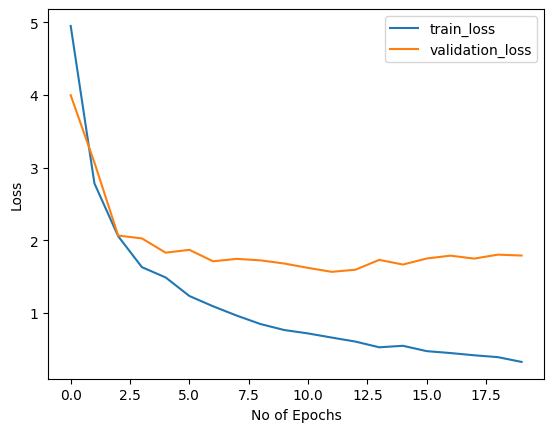

In [15]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [17]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Accuracy : 0.9105646828419106
Test Accuracy : 0.7260569456427955
Validation Accuracy : 0.7232800203097233


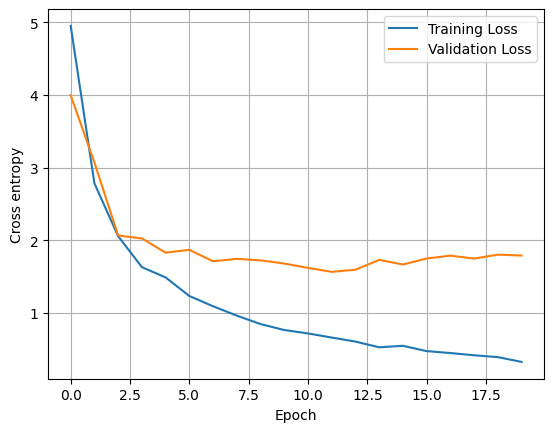

In [18]:
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.grid()
plt.show()


In [19]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.0

    predictions_arr = []
    targets_arr = []

    for features, targets in data_loader:
        features = features.to(device)  # x to device
        targets = targets.to(device)  # y to device

        logits = model(features)  # Call the model (assumes logits are returned)
        probas = F.softmax(logits, dim=1)  # Compute probabilities externally

        cross_entropy += F.cross_entropy(logits, targets).item()

        _, predicted_labels = torch.max(probas, 1)  # y_hat = predicted_labels
        num_examples += targets.size(0)

        correct_pred += (predicted_labels == targets).sum()
        targets_arr.append(targets)
        predictions_arr.append(predicted_labels)

    return correct_pred.float() / num_examples * 100, cross_entropy / num_examples, targets_arr, predictions_arr


In [20]:
dataloaders = {'test': test_loader} # Assuming test_loader is defined as before

test_acc, test_loss, test_targets, test_preds = compute_accuracy_and_loss(model, dataloaders['test'], device=device) # compute accuracy on test dataset
print('Test accuracy: %.2f%%' % (test_acc))

Test accuracy: 73.04%


In [21]:
test_targets = torch.hstack(test_targets).cpu().detach().numpy()
test_preds = torch.hstack(test_preds).cpu().detach().numpy()

In [22]:
print(test_targets.shape)
print(test_preds.shape)

(2318,)
(2318,)


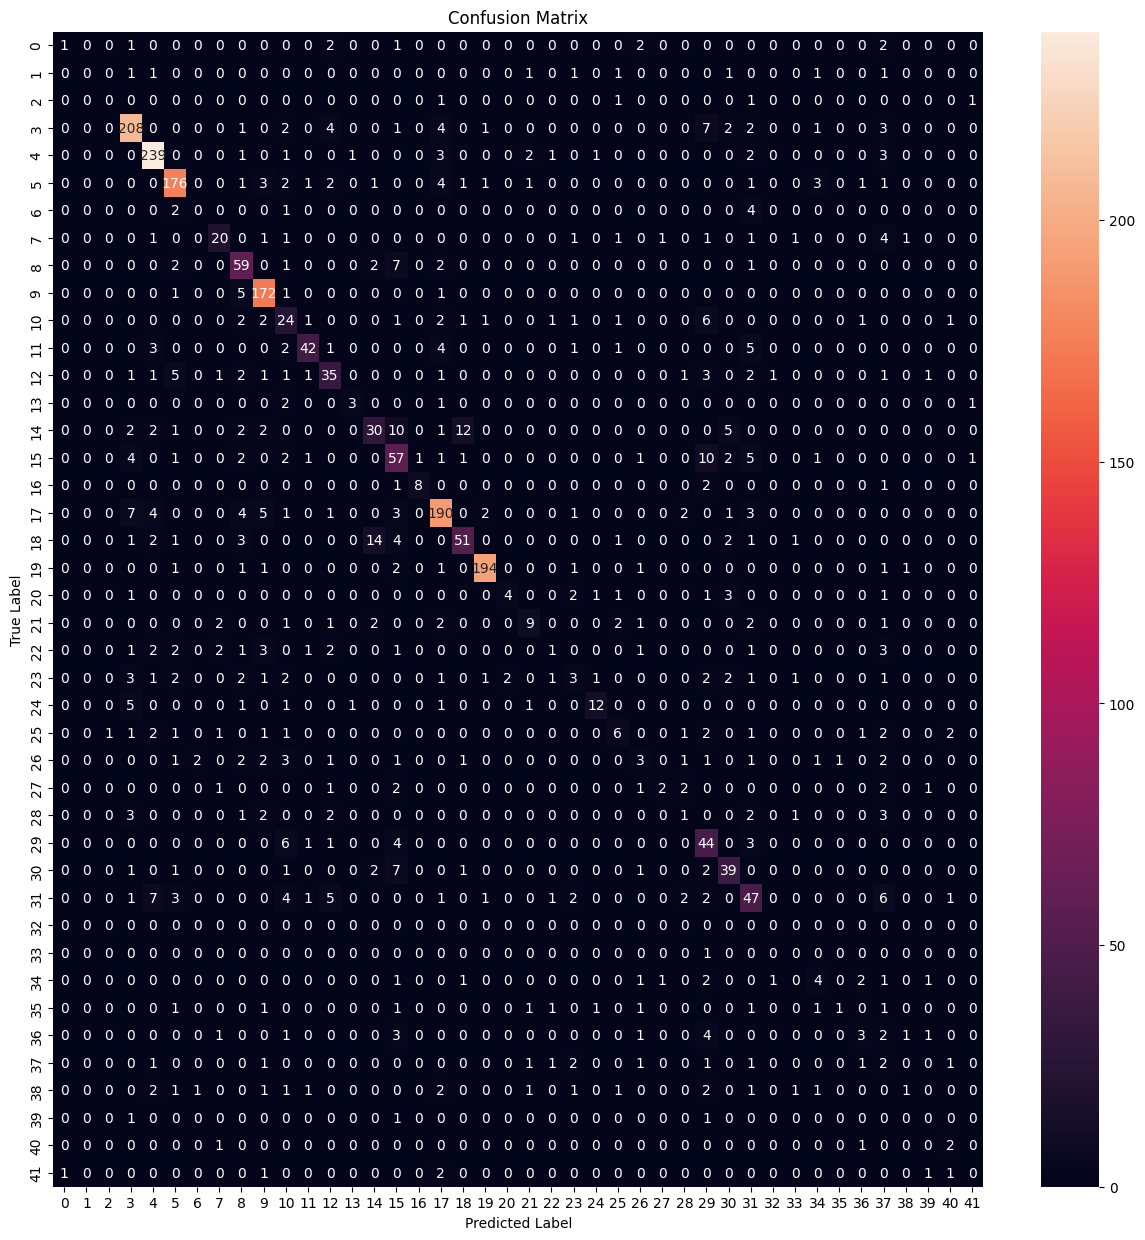

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_targets, test_preds)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming test_targets and test_preds are defined
# Replace with your actual arrays
cm = confusion_matrix(test_targets, test_preds)

# Extract values from the confusion matrix
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives
TP = cm[1, 1]  # True Positives

# Compute KPIs
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

# Print the results
print("Confusion Matrix:")
print(cm)
print("\nKey Performance Indicators:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 1]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]

Key Performance Indicators:
Accuracy: nan
Precision: 0.00
Recall (Sensitivity): 0.00
Specificity: 0.00
F1-Score: 0.00


<ipython-input-27-3119b021ed3f>:14: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = (TP + TN) / (TP + TN + FP + FN)


In [ ]:
# prompt: Lade das model plant_disease_model_1.pt und gebe informationen aus

import torch

model.load_state_dict(torch.load('./plant_disease_model_1.pt'))


# Print model architecture
print(model)

# Print model parameters
for name, param in model.named_parameters():
    print(name, param.shape)

<ipython-input-34-fb3bfca01447>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./plant_disease_model_1.pt'))


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)